In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np

In [3]:
import glob, os
import re

## File paths

# If you use the pickle file -- Skip to that cell

In [10]:
#os.chdir("../LeapMotion/Leap_Motion_Data/")

glob_list = []

#loop through subject folders and glob
for subject in range(25):
    # Change slashes if on windows to \\
    glob_list.append(sorted(glob.glob(str(subject) + "/[A-Z0-9]*.csv")))
    
#function to flatten glob
flatten = lambda l: [item for sublist in l for item in sublist]
glob_list = flatten(glob_list)

In [11]:
#make a list of tuples of hand pairings
lr_pairs = list(zip(*[iter(glob_list)]*2))

# remove all blue files
for i in range(25):
    # Change slashes if on windows to \\
    lr_pairs.remove((str(i)+'/Blue_Left.csv', str(i)+'/Blue_Right.csv'))
# remove "bad" from subject 19
# Change slashes if on windows to \\
lr_pairs.remove(('19/Bad_Left.csv', '19/Bad_Right.csv'))
print(lr_pairs)

[('0/0_Left.csv', '0/0_Right.csv'), ('0/10_Left.csv', '0/10_Right.csv'), ('0/1_Left.csv', '0/1_Right.csv'), ('0/2_Left.csv', '0/2_Right.csv'), ('0/3_Left.csv', '0/3_Right.csv'), ('0/4_Left.csv', '0/4_Right.csv'), ('0/5_Left.csv', '0/5_Right.csv'), ('0/6_Left.csv', '0/6_Right.csv'), ('0/7_Left.csv', '0/7_Right.csv'), ('0/8_Left.csv', '0/8_Right.csv'), ('0/9_Left.csv', '0/9_Right.csv'), ('0/Big_Left.csv', '0/Big_Right.csv'), ('0/Brush_Left.csv', '0/Brush_Right.csv'), ('0/Bug_Left.csv', '0/Bug_Right.csv'), ('0/Candy_Left.csv', '0/Candy_Right.csv'), ('0/CarDrive_Left.csv', '0/CarDrive_Right.csv'), ('0/Cat_Left.csv', '0/Cat_Right.csv'), ('0/Cereal_Left.csv', '0/Cereal_Right.csv'), ('0/Clothes_Left.csv', '0/Clothes_Right.csv'), ('0/Coat_Left.csv', '0/Coat_Right.csv'), ('0/Cold_Left.csv', '0/Cold_Right.csv'), ('0/Come_Left.csv', '0/Come_Right.csv'), ('0/Cost_Left.csv', '0/Cost_Right.csv'), ('0/Cry_Left.csv', '0/Cry_Right.csv'), ('0/Dad_Left.csv', '0/Dad_Right.csv'), ('0/Deaf_Left.csv', '0/Dea

## Create list of DataFrames

In [12]:
df_list = []

for pair in lr_pairs:
    df_left = pd.read_csv(pair[0], index_col=None).drop(['Unnamed: 0'], axis = 1)
    df_right = pd.read_csv(pair[1], index_col=None).drop(['Unnamed: 0'], axis = 1)
    
    #rename columns
    df_left = df_left.add_prefix('left')
    df_right = df_right.add_prefix('right')
    
    #merge
    df = pd.merge(df_left, df_right, left_on='leftTime', right_on='rightTime').drop('rightTime', axis = 1)

    #covert fist column to time object
    df['leftTime'] = pd.to_datetime(df['leftTime'].str[:-3], format = '%H:%M:%S.%f')
    
    #difference between rows
    df = df.diff().iloc[1:]
    df['leftTime'] = df['leftTime'].dt.total_seconds()
    
    df.rename(columns={'leftTime':'time'}, inplace=True)
    
    #add sign and subject using regex of file name
    # Change slashes if on windows to \\
    subject_sign = re.split(r'/', re.findall('^[^_]+(?=_)', pair[0])[0])
    print(subject_sign)
    df.insert(loc = 0, column = 'Subject', value = subject_sign[0])
    df.insert(loc = 0, column = 'Sign', value = subject_sign[1])
    
    df_list.append(df)

['0', '0']
['0', '10']
['0', '1']
['0', '2']
['0', '3']
['0', '4']
['0', '5']
['0', '6']
['0', '7']
['0', '8']
['0', '9']
['0', 'Big']
['0', 'Brush']
['0', 'Bug']
['0', 'Candy']
['0', 'CarDrive']
['0', 'Cat']
['0', 'Cereal']
['0', 'Clothes']
['0', 'Coat']
['0', 'Cold']
['0', 'Come']
['0', 'Cost']
['0', 'Cry']
['0', 'Dad']
['0', 'Deaf']
['0', 'Dog']
['0', 'Drink']
['0', 'Egg']
['0', 'Finish']
['0', 'Go']
['0', 'Good']
['0', 'Green']
['0', 'Happy']
['0', 'Hot']
['0', 'Hungry']
['0', 'Hurt']
['0', 'Milk']
['0', 'Mom']
['0', 'More']
['0', 'Neutral']
['0', 'Orange']
['0', 'Pig']
['0', 'Please']
['0', 'Red']
['0', 'Shoes']
['0', 'Small']
['0', 'Socks']
['0', 'Stop']
['0', 'Store']
['0', 'Thanks']
['0', 'Warm']
['0', 'Water']
['0', 'What']
['0', 'When']
['0', 'Where']
['0', 'Why']
['0', 'With']
['0', 'Work']
['0', 'Yellow']
['1', '0']
['1', '10']
['1', '1']
['1', '2']
['1', '3']
['1', '4']
['1', '5']
['1', '6']
['1', '7']
['1', '8']
['1', '9']
['1', 'Big']
['1', 'Brush']
['1', 'Bug']
['1', 'C

['9', 'Why']
['9', 'With']
['9', 'Work']
['9', 'Yellow']
['10', '0']
['10', '10']
['10', '1']
['10', '2']
['10', '3']
['10', '4']
['10', '5']
['10', '6']
['10', '7']
['10', '8']
['10', '9']
['10', 'Big']
['10', 'Brush']
['10', 'Bug']
['10', 'Candy']
['10', 'CarDrive']
['10', 'Cat']
['10', 'Cereal']
['10', 'Clothes']
['10', 'Coat']
['10', 'Cold']
['10', 'Come']
['10', 'Cost']
['10', 'Cry']
['10', 'Dad']
['10', 'Deaf']
['10', 'Dog']
['10', 'Drink']
['10', 'Egg']
['10', 'Finish']
['10', 'Go']
['10', 'Good']
['10', 'Green']
['10', 'Happy']
['10', 'Hot']
['10', 'Hungry']
['10', 'Hurt']
['10', 'Milk']
['10', 'Mom']
['10', 'More']
['10', 'Neutral']
['10', 'Orange']
['10', 'Pig']
['10', 'Please']
['10', 'Red']
['10', 'Shoes']
['10', 'Small']
['10', 'Socks']
['10', 'Stop']
['10', 'Store']
['10', 'Thanks']
['10', 'Warm']
['10', 'Water']
['10', 'What']
['10', 'When']
['10', 'Where']
['10', 'Why']
['10', 'With']
['10', 'Work']
['10', 'Yellow']
['11', '0']
['11', '10']
['11', '1']
['11', '2']
['11'

['19', 'CarDrive']
['19', 'Cat']
['19', 'Cereal']
['19', 'Clothes']
['19', 'Coat']
['19', 'Cold']
['19', 'Come']
['19', 'Cost']
['19', 'Cry']
['19', 'Dad']
['19', 'Deaf']
['19', 'Dog']
['19', 'Drink']
['19', 'Egg']
['19', 'Finish']
['19', 'Go']
['19', 'Good']
['19', 'Green']
['19', 'Happy']
['19', 'Hot']
['19', 'Hungry']
['19', 'Hurt']
['19', 'Milk']
['19', 'Mom']
['19', 'More']
['19', 'Neutral']
['19', 'Orange']
['19', 'Pig']
['19', 'Please']
['19', 'Red']
['19', 'Shoes']
['19', 'Small']
['19', 'Socks']
['19', 'Stop']
['19', 'Store']
['19', 'Thanks']
['19', 'Warm']
['19', 'Water']
['19', 'What']
['19', 'When']
['19', 'Where']
['19', 'Why']
['19', 'With']
['19', 'Work']
['19', 'Yellow']
['20', '0']
['20', '10']
['20', '1']
['20', '2']
['20', '3']
['20', '4']
['20', '5']
['20', '6']
['20', '7']
['20', '8']
['20', '9']
['20', 'Big']
['20', 'Brush']
['20', 'Bug']
['20', 'Candy']
['20', 'CarDrive']
['20', 'Cat']
['20', 'Cereal']
['20', 'Clothes']
['20', 'Coat']
['20', 'Cold']
['20', 'Come'

# Pickle the dataframe list

In [ ]:
import pickle

with open('sign_frames.pkl', 'wb') as f:
    pickle.dump(df_list, f)

# Load the dataframe from pickle instead of remaking the list

In [4]:
import pickle
import timeit
# This line may need to be commented/uncommented as needed
os.chdir("../LeapMotion/Leap_Motion_Data/")
start_time = timeit.default_timer()

with open('sign_frames.pkl', 'rb') as f:
    df_list = pickle.load(f)
# code you want to evaluate
elapsed = timeit.default_timer() - start_time

In [5]:
df_list[0]

,Sign,Subject,time,left thumbProximal_L_X,left thumbProximal_L_Y,left thumbProximal_L_Z,left thumbDistal_L_X,left thumbDistal_L_Y,left thumbDistal_L_Z,left thumbEF_L_X,...,right armFrontRadius_L_Z,right armFrontUlna_L_X,right armFrontUlna_L_Y,right armFrontUlna_L_Z,right armBackLateral_L_X,right armBackLateral_L_Y,right armBackLateral_L_Z,right armBackMedial_L_X,right armBackMedial_L_Y,right armBackMedial_L_Z
1,0,0,0.028,0.000388,0.000133,0.000050,0.000406,0.000153,0.000063,0.000403,...,-0.000321,-0.000166,0.000114,-0.000298,-8.360000e-05,-0.000393,-0.000142,-0.000071,-0.000331,-0.000119
2,0,0,0.036,0.000420,0.000077,-0.000248,0.000443,0.000085,-0.000239,0.000429,...,-0.000235,-0.000095,0.000121,-0.000193,4.000000e-05,-0.000276,-0.000075,0.000035,-0.000261,-0.000034
3,0,0,0.033,0.000223,0.000264,-0.000160,0.000164,0.000275,-0.000170,0.000121,...,-0.000251,-0.000084,0.000163,-0.000204,-1.250000e-04,-0.000481,0.000008,-0.000147,-0.000522,0.000054
4,0,0,0.034,0.000103,0.000078,-0.000318,0.000105,0.000103,-0.000307,0.000054,...,-0.000213,-0.000179,0.000077,-0.000056,1.000000e-07,-0.000630,0.000164,-0.000104,-0.000869,0.000321
5,0,0,0.036,0.000055,0.000233,-0.000030,0.000002,0.000263,-0.000031,-0.000022,...,-0.000001,0.000016,0.000356,0.000150,5.750000e-04,0.000152,0.000179,0.000504,0.000025,0.000330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,0,0,0.042,0.000234,0.000309,-0.000214,0.000329,0.000273,-0.000204,0.000371,...,0.000295,0.001436,0.000441,0.000373,-8.165000e-04,-0.000436,-0.000397,-0.000785,-0.000404,-0.000319
686,0,0,0.046,0.000256,0.000157,-0.000107,0.000251,0.000190,-0.000097,0.000228,...,0.000138,0.002025,0.000737,0.000454,-1.395300e-03,-0.001677,-0.000466,-0.001304,-0.001543,-0.000149
687,0,0,0.043,0.000210,0.000039,-0.000039,0.000226,0.000065,-0.000026,0.000216,...,-0.000251,0.002495,0.001583,-0.000102,-1.360000e-03,-0.000036,-0.001245,-0.001321,0.000028,-0.001097
688,0,0,0.059,-0.000083,0.000201,0.000012,-0.000046,0.000252,0.000038,-0.000039,...,-0.000735,0.005017,0.002821,0.000149,-2.756600e-03,-0.002480,-0.001475,-0.001811,-0.002021,-0.000591


## Hand Classification

In [6]:
#list of signs included in data set
os.chdir("..")
hands_used  = pd.read_csv("signs_f.csv")

In [7]:
threshold = [(abs(df.iloc[:,3:].filter(regex='left').mean().sum()), df.loc[1, 'Sign']) for df in df_list]

In [8]:
thresh = .000025

In [9]:
#one_hand = [tup[1] for tup in threshold if tup[0] < thresh]
#one_hand = list(set(one_hand))
one_hand = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'Dad', 'Mom', 'Brush', 'Bug', 'Candy', 'Cat', 'Deaf', 'Dog', 'Drink', 'Green', 'Hot', 'Hungry', 'Milk', 'Neutral', 'Orange', 'Pig', 'Please', 'Red', 'Thanks', 'Warm', 'Water', 'Where', 'Why']

In [10]:
#two_hand = [value for value in hands_used.Sign.values if value not in one_hand]
two_hand = ['CarDrive', 'Cereal', 'Clothes', 'Coat', 'Cold', 'Come', 'Cost', 'Cry', 'Egg', 'Finish', 'Go', 'Good', 'Happy', 'Hurt', 'More', 'Shoes', 'Socks', 'Stop', 'Store', 'What', 'With', 'Work', 'Yellow', 'Big', 'Small']

In [11]:
class hand_selection:
    
    def __init__(self, drop_left=False):
        self.drop_left = drop_left
        
    def transform(self, df_list, hand_list):
        if not self.drop_left:
            subset = [df for df in df_list if df.Sign.values[0] in hand_list]
        else:
            subset = [df.drop(df.filter(regex='left').columns, axis=1) \
                      for df in df_list \
                      if df.Sign.values[0] in hand_list]
            
        return subset

## Feature Extraction

In [12]:
class extraction:
    def __init__(self, df):
        self.df = df
        self.features = dict()
        
    def label(self):
        self.features['label'] = self.df['Sign'].iloc[0]
        self.df = self.df.iloc[:, 2:]
        
    def mean(self):
        for col in self.df:
            self.features[col + ' mean'] = self.df[col].mean()
            
    def stdev(self):
        for col in self.df:
            self.features[col + ' stdev'] = self.df[col].std()
            
    def extract_features(self):
        self.label()
        self.mean()
        self.stdev()

In [51]:
from sklearn.preprocessing import StandardScaler

def return_features(df_list, hand_list, drop_left):
    scaler = StandardScaler()
    
    feature_list = []
    
    select_class = hand_selection(drop_left)
    frames = select_class.transform(df_list, hand_list)
    
    for df in frames:
        class_obj = extraction(df)
        class_obj.extract_features()
        feature_list.append(class_obj.features)
        
    feat_df = pd.DataFrame(feature_list)
    
    y = feat_df.label
    X = scaler.fit_transform(feat_df.drop(['label'], axis = 1))
    
    return X, y

In [ ]:
X_one_hand, y_one_hand = return_features(df_list=df_list, 
                                         hand_list=one_hand, 
                                         drop_left=True)

X_two_hand, y_two_hand = return_features(df_list=df_list, 
                                         hand_list=two_hand, 
                                         drop_left=False)

Index(['Sign', 'Subject', 'time', 'right thumbProximal_L_X',
       'right thumbProximal_L_Y', 'right thumbProximal_L_Z',
       'right thumbDistal_L_X', 'right thumbDistal_L_Y',
       'right thumbDistal_L_Z', 'right thumbEF_L_X', 'right thumbEF_L_Y',
       'right thumbEF_L_Z', 'right indexProximal_L_X',
       'right indexProximal_L_Y', 'right indexProximal_L_Z',
       'right indexMedial_L_X', 'right indexMedial_L_Y',
       'right indexMedial_L_Z', 'right indexDistal_L_X',
       'right indexDistal_L_Y', 'right indexDistal_L_Z', 'right indexEF_L_X',
       'right indexEF_L_Y', 'right indexEF_L_Z', 'right middleProximal_L_X',
       'right middleProximal_L_Y', 'right middleProximal_L_Z',
       'right middleMedial_L_X', 'right middleMedial_L_Y',
       'right middleMedial_L_Z', 'right middleDistal_L_X',
       'right middleDistal_L_Y', 'right middleDistal_L_Z',
       'right middleEF_L_X', 'right middleEF_L_Y', 'right middleEF_L_Z',
       'right ringProximal_L_X', 'right ringProxi

## Model Selection

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

### Two Hand

In [39]:
import warnings
warnings.filterwarnings('ignore')

lda_accuracy = []
qda_accuracy = []
knn_accuracy = []
rf_accuracy = []
nb_accuracy = []
svm_accuracy = []
mlp_accuracy = []
LAYER_SIZE = (X_two_hand[0].size,64,len(one_hand)+len(two_hand))

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X_two_hand, 
                                                        y_two_hand,
                                                        stratify=y_two_hand, 
                                                        test_size=0.25)

    clf = LinearDiscriminantAnalysis()
    clf.fit(X_train, y_train)
    lda_accuracy.append(clf.score(X_test,y_test))
    
    clf = SVC(decision_function_shape='ovo', kernel='linear', C=1, gamma=1)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    svm_accuracy.append(score)
    
    clf = MLPClassifier(solver='adam', alpha=0.0001, activation='tanh', hidden_layer_sizes=LAYER_SIZE)
    clf.fit(X_train, y_train)
    mlp_accuracy.append(clf.score(X_test, y_test))
    print(mlp_accuracy[-1])
    
    """
    clf = QuadraticDiscriminantAnalysis()
    clf.fit(X_train, y_train)
    qda_accuracy.append(clf.score(X_test,y_test))
    
    neigh = KNeighborsClassifier(n_neighbors=15)
    neigh.fit(X_train, y_train)
    knn_accuracy.append(neigh.score(X_test,y_test))    
    
    clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
    clf.fit(X_train, y_train)
    rf_accuracy.append(clf.score(X_test,y_test))

    clf = GaussianNB()
    clf.fit(X_train, y_train)
    nb_accuracy.append(clf.score(X_test,y_test))  
    """

0.8343949044585988
0.7133757961783439
0.821656050955414
0.7707006369426752
0.8089171974522293
0.7770700636942676
0.7834394904458599
0.8152866242038217
0.8280254777070064
0.4840764331210191
0.7961783439490446
0.29936305732484075
0.03821656050955414
0.7770700636942676


KeyboardInterrupt: 

# GridCVSearch for SVM (run after the above to tune)

In [43]:
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
parameters = {'solver': ['lbfgs'], 'max_iter': [10,100,200], 'alpha': 10.0 ** -np.arange(1, 10), 'hidden_layer_sizes':np.arange(10, 15), 'random_state':[0,1,2,3,4,5,6,7,8,9]}
grid = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1) 
    
# fitting the model for grid search 
grid.fit(X_train, y_train) 
print(grid.best_params_)

KeyboardInterrupt: 

In [29]:
accuracy_list = [lda_accuracy, svm_accuracy, mlp_accuracy]

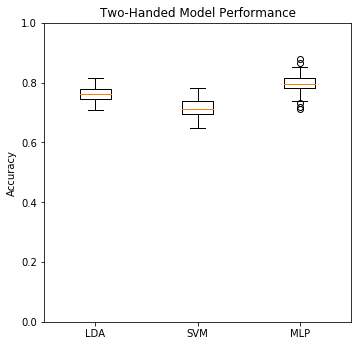

In [30]:
plt.figure(figsize=(5.5, 5.5))
plt.ylim(0, 1)
plt.boxplot(accuracy_list, labels = ['LDA', 'SVM', 'MLP'])
plt.title('Two-Handed Model Performance')
plt.ylabel('Accuracy')
plt.savefig('plots/two_hand_model_performance_svm_ovo_linear_kernel.png', dpi = 500)
plt.show()

In [33]:
from statistics import mean 
print(mean(lda_accuracy))
print(mean(svm_accuracy))
print(mean(mlp_accuracy))

0.7620382165605096
0.7140764331210191
0.7987898089171975


### One Hand

In [47]:
lda_accuracy = []
qda_accuracy = []
knn_accuracy = []
rf_accuracy = []
nb_accuracy = []
svm_accuracy = []
mlp_accuracy = []
LAYER_SIZE = (X_two_hand[0].size,64,len(one_hand))

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X_one_hand, 
                                                        y_one_hand,
                                                        stratify=y_one_hand, 
                                                        test_size=0.25)
    clf = LinearDiscriminantAnalysis()
    clf.fit(X_train, y_train)
    lda_accuracy.append(clf.score(X_test,y_test))
    
    clf = SVC(decision_function_shape='ovo', kernel='linear', C=1, gamma=1)
    clf.fit(X_train, y_train)
    svm_accuracy.append(clf.score(X_test, y_test))
    
    clf = MLPClassifier(solver='adam', alpha=0.0001, activation='tanh', hidden_layer_sizes=LAYER_SIZE)
    clf.fit(X_train, y_train)
    mlp_accuracy.append(clf.score(X_test, y_test))
    print(clf.predict([X_test[0]]))
    
    """
    clf = QuadraticDiscriminantAnalysis()
    clf.fit(X_train, y_train)
    qda_accuracy.append(clf.score(X_test,y_test))
    
    neigh = KNeighborsClassifier(n_neighbors=15)
    neigh.fit(X_train, y_train)
    knn_accuracy.append(neigh.score(X_test,y_test))    
    
    clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
    clf.fit(X_train, y_train)
    rf_accuracy.append(clf.score(X_test,y_test))

    clf = GaussianNB()
    clf.fit(X_train, y_train)
    nb_accuracy.append(clf.score(X_test,y_test))""" 

['Where']
['Dog']
['1']
['Neutral']
['Water']
['Please']
['Dog']
['8']
['8']
['Hot']
['Hungry']
['Mom']
['Where']
['4']
['6']
['Hot']
['8']
['Pig']
['Warm']
['Dad']
['Orange']
['2']
['Cat']
['4']
['Candy']
['Where']
['8']
['Dad']
['9']
['Warm']
['0']
['7']


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/thomasorth/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-47-6f27b94fd976>", line 20, in <module>
    clf.fit(X_train, y_train)
  File "/Users/thomasorth/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py", line 209, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/Users/thomasorth/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py", line 268, in _dense_fit
    max_iter=self.max_iter, random_seed=random_seed)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/thomasorth/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_tr

KeyboardInterrupt: 

In [43]:
print(mean(lda_accuracy))
print(mean(svm_accuracy))
print(mean(mlp_accuracy))

0.8480281690140845
0.6914553990610328
0.7865258215962442


In [44]:
accuracy_list = [lda_accuracy, svm_accuracy, mlp_accuracy]

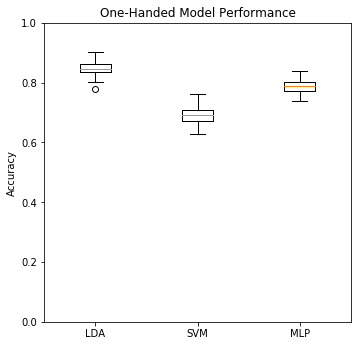

In [45]:
plt.figure(figsize=(5.5, 5.5))
plt.ylim(0, 1)
plt.boxplot(accuracy_list, labels = ['LDA', 'SVM', 'MLP'])
plt.title('One-Handed Model Performance')
plt.ylabel('Accuracy')
plt.savefig('plots/one_hand_model_performance.png', dpi = 500)
plt.show()

## Model

### Two Hand

In [ ]:
import warnings
warnings.filterwarnings('ignore')

accuracy_two_hand = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X_two_hand, 
                                                        y_two_hand,
                                                        stratify=y_two_hand, 
                                                        test_size=0.25)

    clf = LinearDiscriminantAnalysis()
    clf.fit(X_train, y_train)
    #clf.scalings_
    accuracy_two_hand.append(clf.score(X_test,y_test))

### One Hand

In [ ]:
accuracy_one_hand = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X_one_hand, 
                                                        y_one_hand,
                                                        stratify=y_one_hand, 
                                                        test_size=0.25)

    clf = LinearDiscriminantAnalysis()
    clf.fit(X_train, y_train)
    #clf.scalings_
    accuracy_one_hand.append(clf.score(X_test,y_test))

# Accuracy Plot

In [ ]:
plt.hist(accuracy_one_hand, bins=10, label = 'One hand', alpha=0.5)
plt.hist(accuracy_two_hand, bins=10, label = 'Two hand', alpha=0.5)
plt.xlabel("Classification Accuracy")
plt.ylabel("Count")
plt.title("Model Accuracy")
plt.legend(loc='upper right')
plt.savefig('plots/lda_both_hands.png', dpi = 750)
plt.show()

## Confusion

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_two_hand, 
                                                    y_two_hand,
                                                    stratify=y_two_hand, 
                                                    test_size=0.25,
                                                    random_state = 42)

clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)

two_hand_pred = pd.DataFrame(zip(y_test, clf.predict(X_test)), columns=['actual', 'predicted'])

clf.score(X_test,y_test)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_one_hand, 
                                                    y_one_hand,
                                                    stratify=y_one_hand, 
                                                    test_size=0.25,
                                                    random_state = 42)

clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)

one_hand_pred = pd.DataFrame(zip(y_test, clf.predict(X_test)), columns=['actual', 'predicted'])

clf.score(X_test,y_test)

In [ ]:
combined_pred = pd.concat([one_hand_pred, two_hand_pred])

In [ ]:
misclass = combined_pred[combined_pred.actual != combined_pred.predicted]

In [ ]:
misclass_groupby = misclass.groupby(['actual', 'predicted'])[['predicted']].agg('count')
misclass_groupby[misclass_groupby > 1].dropna()

Number of times a sign is misclassified (False Negative):

In [ ]:
pd.DataFrame(misclass.groupby(['actual'])[['predicted']].agg('count')['predicted'].sort_values(ascending = False)).iloc[:10]

Number of times a sign is incorrectly assigned (False Poitive):

In [ ]:
pd.DataFrame(misclass.groupby(['predicted'])[['predicted']].agg('count')['predicted'].sort_values(ascending = False)).iloc[:10]

## One Versus All ROC Curves

### Two Hand

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

In [ ]:
from sklearn.preprocessing import label_binarize

X_train, X_test, y_train, y_test = train_test_split(X_two_hand, 
                                                    label_binarize(y_two_hand, classes=two_hand),
                                                    stratify=label_binarize(y_two_hand, classes=two_hand), 
                                                    test_size=0.25,
                                                    random_state = 42)

clf = OneVsRestClassifier(LinearDiscriminantAnalysis())
clf.fit(X_train, y_train)

y_score = clf.fit(X_train, y_train).decision_function(X_test)

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt

labels = two_hand
n_classes = len(labels)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC ' + labels[i])
    plt.legend(loc="lower right")
    plt.savefig('plots/' + labels[i] + '.png', dpi = 750)
    plt.show()

### One Hand

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_one_hand, 
                                                    label_binarize(y_one_hand, classes=one_hand),
                                                    stratify=label_binarize(y_one_hand, classes=one_hand), 
                                                    test_size=0.25,
                                                    random_state = 42)

clf = OneVsRestClassifier(LinearDiscriminantAnalysis())
clf.fit(X_train, y_train)

y_score = clf.fit(X_train, y_train).decision_function(X_test)

In [ ]:
labels = one_hand
n_classes = len(labels)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC ' + labels[i])
    plt.legend(loc="lower right")
    plt.savefig('plots/' + labels[i] + '.png', dpi = 750)
    plt.show()